hello kagglers, this is my first kernel on kaggle. I would like to show my Monkey Classifier using ResNet-50. I built it using Keras pre trained model, with difference on last few layer. Feel free to write any advice for on the comment section, thanks!

**1. Importing required Library**

In [2]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGE = True

**2. Define some constant needed throughout the script**

In [3]:
N_CLASSES = 10 #define classes of the dataset (10 monkey species)
EPOCHS = 15 #define epochs or maximum iteration
PATIENCE = 5 #define early stopping steps
#TRAIN_PATH= '../input/training/training/' 
#VALID_PATH = '../input/validation/validation/'
TRAIN_PATH= '10-monkey-species/training/training/'
VALID_PATH = '10-monkey-species/validation/validation/'
MODEL_CHECK_WEIGHT_NAME = 'resnet_monki_v1_chk.h5'

**3. Define model to be used**
we freeze the pre trained resnet model weight, and add few layer on top of it to utilize our custom dataset


In [4]:
K.set_learning_phase(0)
model = ResNet50(input_shape=(224,224,3),include_top=False, weights='imagenet', pooling='avg')
K.set_learning_phase(1)
x = model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASSES, activation='softmax', name='custom_output')(x)
custom_resnet = Model(inputs=model.input, outputs = output)

for layer in model.layers:
    layer.trainable = False

custom_resnet.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
custom_resnet.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

**4. Load dataset to be used**

In [5]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
traingen = datagen.flow_from_directory(TRAIN_PATH, target_size=(224,224), batch_size=32, class_mode='categorical')
validgen = datagen.flow_from_directory(VALID_PATH, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=False)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


**5. Train Model**
we use ModelCheckpoint to save the best model based on validation accuracy


In [6]:
es_callback = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, mode='max')
mc_callback = ModelCheckpoint(filepath=MODEL_CHECK_WEIGHT_NAME, monitor='val_accuracy', save_best_only=True, mode='max')
train_history = custom_resnet.fit_generator(traingen, steps_per_epoch=len(traingen), epochs= EPOCHS, validation_data=traingen, validation_steps=len(validgen), verbose=2, callbacks=[es_callback, mc_callback])



Epoch 1/15
 - 211s - loss: 1.4182 - accuracy: 0.5619 - val_loss: 0.3081 - val_accuracy: 0.8819
Epoch 2/15
 - 217s - loss: 0.2869 - accuracy: 0.9062 - val_loss: 0.1033 - val_accuracy: 0.9340
Epoch 3/15
 - 183s - loss: 0.1461 - accuracy: 0.9545 - val_loss: 0.2167 - val_accuracy: 0.9618
Epoch 4/15
 - 175s - loss: 0.1361 - accuracy: 0.9545 - val_loss: 0.1930 - val_accuracy: 0.9699
Epoch 5/15
 - 177s - loss: 0.0823 - accuracy: 0.9727 - val_loss: 0.0105 - val_accuracy: 0.9896
Epoch 6/15
 - 183s - loss: 0.0867 - accuracy: 0.9745 - val_loss: 0.0106 - val_accuracy: 0.9792
Epoch 7/15
 - 177s - loss: 0.0651 - accuracy: 0.9791 - val_loss: 0.0322 - val_accuracy: 0.9931
Epoch 8/15
 - 173s - loss: 0.0426 - accuracy: 0.9818 - val_loss: 0.0187 - val_accuracy: 0.9850
Epoch 9/15
 - 174s - loss: 0.0309 - accuracy: 0.9918 - val_loss: 0.0712 - val_accuracy: 0.9861
Epoch 10/15
 - 178s - loss: 0.0390 - accuracy: 0.9854 - val_loss: 0.0120 - val_accuracy: 0.9931
Epoch 11/15
 - 184s - loss: 0.0264 - accuracy: 0

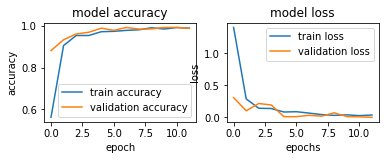

In [7]:
plt.figure(1)
plt.subplot(221)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','validation accuracy'])

plt.subplot(222)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

**7. Load Last Checkpoint Weight**

In [8]:
custom_resnet.load_weights(MODEL_CHECK_WEIGHT_NAME)

**7. Print validation confusion matrix, classification report, and accuracy**

In [9]:
predict = custom_resnet.predict_generator(validgen, steps=len(validgen), verbose=1)
test_labels = validgen.classes
confusion_matrix(test_labels, predict.argmax(axis=1))


9/9 [==============================] - 44s 5s/step


array([[24,  0,  0,  0,  0,  0,  0,  0,  1,  1],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0, 28,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 24,  0,  1,  0,  1,  0],
       [ 0,  1,  0,  0,  0, 25,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 26,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 27,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 25]], dtype=int64)

In [16]:
cr_labels = list(validgen.class_indices.keys())
print(classification_report(test_labels, predict.argmax(axis=1), target_names=cr_labels))

              precision    recall  f1-score   support

          n0       1.00      0.92      0.96        26
          n1       0.93      1.00      0.97        28
          n2       1.00      1.00      1.00        27
          n3       1.00      0.93      0.97        30
          n4       0.92      0.92      0.92        26
          n5       1.00      0.89      0.94        28
          n6       0.90      1.00      0.95        26
          n7       1.00      0.93      0.96        28
          n8       0.87      1.00      0.93        27
          n9       0.96      0.96      0.96        26

    accuracy                           0.96       272
   macro avg       0.96      0.96      0.96       272
weighted avg       0.96      0.96      0.96       272



In [11]:
accuracy_score(test_labels,predict.argmax(axis=1))

0.9558823529411765